# Calculating Expected Field Goal% (xFG%)

$xFG(x) = P$(`SHOT_MADE` $=1∣$ Shot Context)

### Features Used
| Feature                        | Why                       |
| ------------------------------ | ------------------------- |
| Shot location (x, y)           | Geometry                  |
| Shot distance                  | Nonlinear effect          |
| Shot angle                     | Corner vs above-the-break |
| Shot type (2PT / 3PT)          | Massive baseline shift    |
| Corner 3 indicator             | Known efficiency bump     |
| Shot clock time                | Rush effect               |
| Catch-and-shoot vs off-dribble | Difficulty                |
| Dribble count                  | Proxy for creation        |


In [1]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import shotchartdetail
import numpy as np
import pandas as pd
import json


In [19]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent  # adjust if your notebook is nested differently
sys.path.append(str(ROOT))

from src.data_io.save_load import load_json, save_json
from src.viz.heatmaps import build_xfg_heatmap, plot_xfg_heatmap_with_labels
from src.viz.court import draw_half_court

from src.tracking.release import find_release_frame_idx
from src.processing.indexing import find_event_for_shot_by_clock, build_tracking_event_index
from src.features.defense_single import compute_pre_shot_defense_features
from src.features.defense_batch import compute_defense_features_for_shots


## Import Data

In [5]:
shots_raw = shotchartdetail.ShotChartDetail(
    team_id=0,                    # all teams
    player_id=0,                  # all players
    season_nullable="2015-16",
    season_type_all_star="Regular Season",
    context_measure_simple="FGA"  # field goal attempts
).get_data_frames()[0]


In [7]:
shots = shots_raw.copy()
# Coord Normalization
shots["x_ft"] = shots["LOC_X"] / 12
shots["y_ft"] = shots["LOC_Y"] / 12

shots["shot_dist"] = np.sqrt(shots.x_ft**2 + shots.y_ft**2)
shots["angle"] = np.arctan2(shots.x_ft, shots.y_ft)

# Shot Type
shots["is_three"] = shots["SHOT_TYPE"].str.contains("3PT").astype(int)
shots["is_corner"] = ((np.abs(shots.x_ft) > 22) & (shots.y_ft < 14)).astype(int)

# Shot Zone
shots['SHOT_ZONE_BASIC'] = shots['SHOT_ZONE_BASIC'].astype(str)

shots['GAME_ID'] = shots['GAME_ID'].astype(int)


## Calculate xFG with Offensive Stats
Use shot chart data to calculate expected field goal for all shots

### Feature Pipeline

In [8]:
feature_cols_num = [
    "shot_dist",
    "angle",
    "is_three",
    "is_corner",
]

feature_cols_cat = ["SHOT_ZONE_BASIC"]

missing = [c for c in (feature_cols_num + feature_cols_cat) if c not in shots.columns]
if missing:
    raise ValueError(f"Missing features in shots: {missing}")

preprocess = ColumnTransformer([
    ("num", StandardScaler(), feature_cols_num),
    ("cat", OneHotEncoder(drop="first"), feature_cols_cat)
])

shots.fillna(0, inplace=True)

#### Test Train Split
60/20/20

In [9]:
shots["GAME_DATE"] = pd.to_datetime(shots["GAME_DATE"].astype(str), format="%Y%m%d", errors="coerce")
train_idx = shots.index[shots["GAME_DATE"] < "2016-01-01"]
val_idx   = shots.index[(shots["GAME_DATE"] >= "2016-01-01") & (shots["GAME_DATE"] < "2016-02-15")]
test_idx  = shots.index[shots["GAME_DATE"] >= "2016-02-15"]

### MODEL
Here we fit a logistic regression model, using "shot_made" as our target, then also fit a calibrated model which makes our data more normal.

In [10]:
num_cols = feature_cols_num
cat_cols = feature_cols_cat  

# Ensure cat_cols are strings
for c in cat_cols:
    shots[c] = shots[c].astype(str)

X_train = shots.loc[train_idx, num_cols + cat_cols]
y_train = shots.loc[train_idx, "SHOT_MADE_FLAG"].astype(int)

X_val   = shots.loc[val_idx, num_cols + cat_cols]
y_val   = shots.loc[val_idx, "SHOT_MADE_FLAG"].astype(int)

X_test  = shots.loc[test_idx, num_cols + cat_cols]
y_test  = shots.loc[test_idx, "SHOT_MADE_FLAG"].astype(int)

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

base_model = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(
        l1_ratio=0.0,
        C=1.0,
        solver="lbfgs",
        max_iter=200
    ))
])

base_model.fit(X_train, y_train)

calibrator = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic"   # or "sigmoid" if you want smoother/less overfit
)

calibrator.fit(X_val, y_val)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...x_iter=200))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the c

### Model Mectrics


In [11]:
def eval_probs(name, y_true, p):
    print(f"\n{name}")
    print("  log loss:", log_loss(y_true, p))
    print("  brier   :", brier_score_loss(y_true, p))

p_val  = calibrator.predict_proba(X_val)[:, 1]
p_test = calibrator.predict_proba(X_test)[:, 1]

eval_probs("Validation", y_val, p_val)
eval_probs("Test", y_test, p_test)


Validation
  log loss: 0.6504018680570768
  brier   : 0.23010235151571715

Test
  log loss: 0.6476522923840825
  brier   : 0.22854687427932668


#### Calibrate xFG

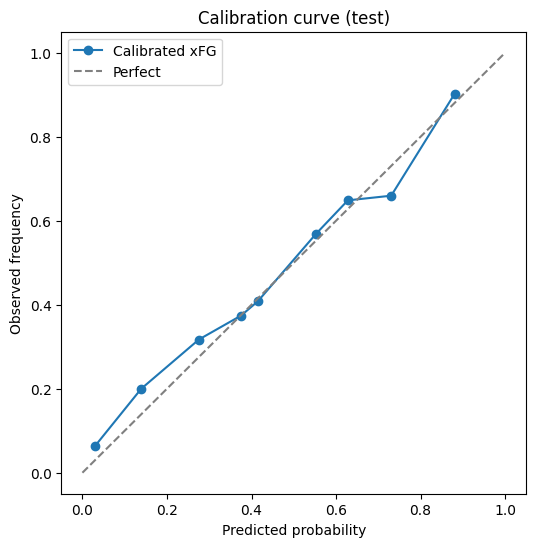

In [12]:
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated xFG")
plt.plot([0,1],[0,1], "--", color="gray", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve (test)")
plt.legend()
plt.show()

### Convert -> Expected Points Per Shot

In [13]:
X_all = shots[feature_cols_num + feature_cols_cat].copy()
shots["xFG_base"]  = calibrator.predict_proba(X_all)[:,1]
shots["xPPS_base"] = shots["xFG_base"] * np.where(shots["is_three"], 3, 2)

## Generate Heatmap of xFG
For visualizations and as a baseline comparison between players

### Plot Heatmap

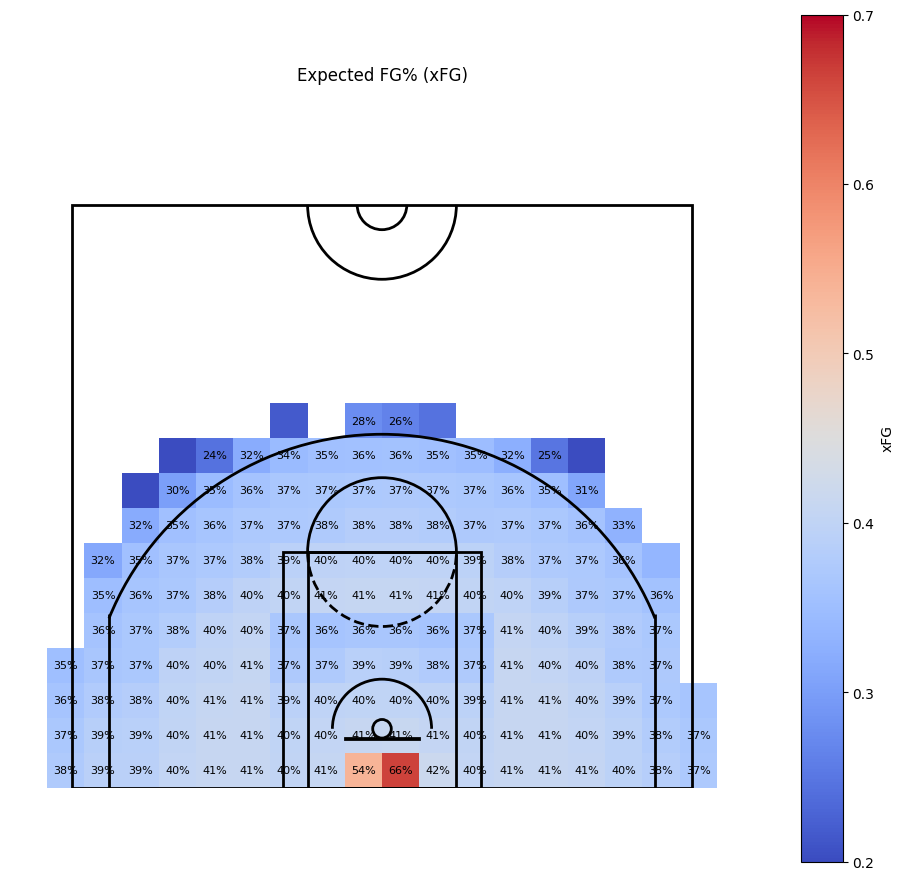

In [14]:
# 1) Build the xFG matrix + attempts
mat, att, x_edges, y_edges = build_xfg_heatmap(
    shots,
    prob_col="xFG_base",
    n_bins_x=20,
    n_bins_y=20,
    min_attempts=20
)

# 2) Plot with labels over the whole half-court
plot_xfg_heatmap_with_labels(
    mat,
    x_edges,
    y_edges,
    draw_half_court_fn=draw_half_court,
    title="Expected FG% (xFG)",
    vmin=0.2,
    vmax=0.7,
    label_fmt="{:.0%}",
    fontsize=8,
    min_show_attempts=50,
    att=att
)

## Add Defensive Data
We want to add defensive data to the model

In [15]:
# Tag only relevant columns for merging
relevant_columns =[
    'GAME_ID',
    'GAME_EVENT_ID',
    'PERIOD',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING',
    'SHOT_MADE_FLAG',
    'LOC_X',
    'LOC_Y',
    'PLAYER_ID',
    'TEAM_ID'
]

# Create filtered DataFrame
shots_filtered = shots[relevant_columns + ["xFG_base", "xPPS_base"]].copy()

# Add game_clock column
shots_filtered["game_clock"] = (
    shots_filtered["MINUTES_REMAINING"] * 60
    + shots_filtered["SECONDS_REMAINING"]
)

In [16]:
shots_filtered.head(3)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_MADE_FLAG,LOC_X,LOC_Y,PLAYER_ID,TEAM_ID,xFG_base,xPPS_base,game_clock
0,21500001,2,1,11,41,0,-17.0,-6.0,203083,1610612765,0.528038,1.056075,701
1,21500001,5,1,11,21,1,117.0,67.0,202694,1610612765,0.410471,0.820942,681
2,21500001,6,1,11,0,1,76.0,95.0,200794,1610612737,0.358679,0.717358,660


### Load/Flatten JSON Data

In [ ]:
# Load tracking data
tracking_events = load_json("data/processed/0021500622_processed.json")

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/0021500622_processed.json'

In [18]:
# Flatten tracking events
tracking_rows = []

for event in tracking_events:
    game_id = event["gameid"]
    event_id = event["event_id"]
    quarter = event["quarter"]

    for frame in event["frames"]:
        tracking_rows.append({
            "GAME_ID": game_id,
            "EVENT_ID": event_id,
            "QUARTER": quarter,
            "frame_id": frame["frame_id"],
            "game_clock": frame["game_clock"],
            "shot_clock": frame.get("shot_clock"),
            "players": frame["players"],   # keep raw for now
            "ball": frame.get("ball")
        })

tracking_df = pd.DataFrame(tracking_rows)

NameError: name 'tracking_events' is not defined

In [ ]:
# Tracking data preview
tracking_df.head(3)

,GAME_ID,EVENT_ID,QUARTER,frame_id,game_clock,shot_clock,players,ball
0,21500622,1,1,1,623.59,15.99,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.64068, 'y': 45.40327, 'z': 3.54135}"
1,21500622,1,1,2,623.55,15.96,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.52319, 'y': 45.27989, 'z': 3.6859}"
2,21500622,1,1,3,623.51,15.93,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.38205, 'y': 45.16353, 'z': 3.80584}"


### Merge Tracking Data with Shot Data

In [ ]:
GAME_ID = tracking_df.loc[0, "GAME_ID"]
EVENT_ID = tracking_df.loc[0, "EVENT_ID"]

shots_g = shots_filtered[shots_filtered["GAME_ID"] == GAME_ID]
tracking_g = tracking_df[tracking_df["GAME_ID"] == GAME_ID]

In [ ]:
shots_g.head(3)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_MADE_FLAG,LOC_X,LOC_Y,PLAYER_ID,TEAM_ID,xFG_base,xPPS_base,game_clock
104540,21500622,2,1,11,43,1,0.0,1.0,101106,1610612744,0.880925,1.761849,703
104541,21500622,3,1,11,16,1,-14.0,8.0,2544,1610612739,0.553121,1.106243,676
104542,21500622,4,1,11,3,1,-125.0,254.0,201939,1610612744,0.321010,0.963031,663


### Build Tracking Index

In [ ]:
# Build tracking event index
event_index = build_tracking_event_index(tracking_events)
event_index.head()

,gameid,quarter,event_list_idx,gc_start,gc_end,n_frames
0,21500622,1,0,623.59,617.63,150
1,21500622,1,1,623.59,610.24,335
2,21500622,1,2,531.89,524.41,438
3,21500622,1,3,531.89,524.41,438
4,21500622,1,4,530.37,509.41,525


### Add Defensive Stats

In [ ]:
shot = shots_g.iloc[30]
gameid = int(shot["GAME_ID"])
quarter = int(shot["PERIOD"])
shot_gc = float(shot["game_clock"])

ev_idx, info = find_event_for_shot_by_clock(event_index, gameid, quarter, shot_gc)
print(ev_idx, info)

34 {'reason': 'ok', 'center_diff': 1.2700000000000102, 'gc_start': 176.67, 'gc_end': 158.79}


In [ ]:
event = tracking_events[ev_idx]
frames = event["frames"]

release_idx, rinfo = find_release_frame_idx(
    event_frames=frames,
    shot_game_clock=shot_gc,
    match="prev",
    max_time_diff=0.8
)

print("release_idx:", release_idx, rinfo)

release_idx: 191 {'reason': 'ok', 'matched_game_clock': 169.03, 'dt': 0.030000000000001137, 'shot_gc': 169.0, 'num_candidates': 448}


In [ ]:
feats = compute_pre_shot_defense_features(
    event_frames=frames,
    release_frame_idx=release_idx,
    shooter_id=int(shot["PLAYER_ID"]),
    offense_team_id=int(shot["TEAM_ID"]),
    fps=25,
    window_seconds=1.0,   # 25 frames
    smooth_window=5
)
feats

{'close_def_id': 203110,
 'close_def_dist_release': 4.993828447363805,
 'close_def_dist_min': 4.993828447363805,
 'close_def_dist_mean': 5.4986852661742756,
 'close_def_closing_speed_mean': -1.040843490311524,
 'close_def_closing_speed_min': -2.497576922212641,
 'def_speed_mean': 2.971593630222508,
 'def_speed_max': 3.5001814261155895,
 'def_accel_mean': 2.6752023582247553,
 'def_accel_max': 7.425309123878254,
 'shooter_speed_mean': 2.8396244205001313,
 'shooter_speed_max': 4.027728527572757,
 'shooter_accel_mean': 4.662633725487982,
 'shooter_accel_max': 12.983482120455363,
 'window_frames': 26,
 'game_clock_release': 169.03,
 'shot_clock_release': 3.83}

In [ ]:
def_feats_df = compute_defense_features_for_shots(
    shots_g,
    tracking_events,
    event_index,
    window_seconds=1.0
)
def_feats_df.head()

,close_def_id,close_def_dist_release,close_def_dist_min,close_def_dist_mean,close_def_closing_speed_mean,close_def_closing_speed_min,def_speed_mean,def_speed_max,def_accel_mean,def_accel_max,shooter_speed_mean,shooter_speed_max,shooter_accel_mean,shooter_accel_max,window_frames,game_clock_release,shot_clock_release,release_idx
shot_index,,,,,,,,,,,,,,,,,,
104545,101106,4.987178,4.987178,7.940951,-5.946088,-7.494743,14.251189,14.952584,3.020805,7.275966,16.081145,17.255065,3.380943,7.433706,26,617.03,21.72,164
104546,2747,2.784622,2.727416,3.803892,-2.366713,-4.742199,7.216841,9.855583,5.548112,10.658684,9.376050,12.851462,10.286402,24.658259,26,610.24,24.00,334
104551,203084,13.052854,13.052854,13.879883,-0.954502,-2.337959,14.444701,14.985646,1.951771,4.857779,11.890170,12.715391,1.671228,3.731838,26,516.01,22.57,359
104552,201567,3.238877,2.202601,3.094208,0.898105,-0.476788,9.564326,11.209472,4.650577,11.870451,10.710293,13.155977,6.231974,10.759305,26,503.01,23.17,309
104553,202389,15.542483,9.949742,12.834109,5.259424,2.514807,10.358150,12.189738,4.505002,13.466623,13.653640,15.155399,3.536798,7.147216,26,486.02,22.94,163


In [ ]:
shots_g_def = shots_g.join(def_feats_df, how="inner")
shots_g_def.columns

Index(['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'SHOT_MADE_FLAG', 'LOC_X', 'LOC_Y', 'PLAYER_ID',
       'TEAM_ID', 'xFG_base', 'xPPS_base', 'game_clock', 'close_def_id',
       'close_def_dist_release', 'close_def_dist_min', 'close_def_dist_mean',
       'close_def_closing_speed_mean', 'close_def_closing_speed_min',
       'def_speed_mean', 'def_speed_max', 'def_accel_mean', 'def_accel_max',
       'shooter_speed_mean', 'shooter_speed_max', 'shooter_accel_mean',
       'shooter_accel_max', 'window_frames', 'game_clock_release',
       'shot_clock_release', 'release_idx'],
      dtype='object')